# Part 3, Fine Tuning Sentiments Using BERT + Topics

In [1]:
# !pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 981 kB 50.1 MB/s 
     |████████████████████████████████| 263 kB 71.8 MB/s 
     |████████████████████████████████| 2.8 MB 62.3 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 468 kB 67.7 MB/s 
     |████████████████████████████████| 596 kB 53.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 48.3 MB/s 
     |████████████████████████████████| 880 kB 72.2 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=f1855350c42ad35a447a622a897afcce3ffc1ca74765bc347baecc82cb2a17aa
  Stored in directory: /root/.cache/pip/wheels/0a/b3/dd/512a01ea0b4f31d96163518b58361bb72d3bcb916d291052e7
  Cr

In [2]:
# !pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import ktrain
from joblib import dump, load

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
zero_shot_sentiments = pd.read_csv("zero_shot_sentiments.csv")
zero_shot_sentiments.head()

,Unnamed: 0,Unnamed: 0.1,date,clean_text,clean_title,positive,negative
0,0,0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0.295749,0.957052
1,1,1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0.002615,0.986636
2,2,2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0.040025,0.966754
3,3,3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0.892183,0.033660
4,4,4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,0.915046,0.068743


In [5]:
zero_shot_sentiments.shape

(165360, 7)

In [6]:
zero_shot_sentiments.drop(columns=[zero_shot_sentiments.columns[0], zero_shot_sentiments.columns[1]], inplace=True)

In [7]:
# !pip install pyLDAvis
zero_shot_sentiments.head()

,date,clean_text,clean_title,positive,negative
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0.295749,0.957052
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0.002615,0.986636
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0.040025,0.966754
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0.892183,0.033660
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,0.915046,0.068743


In [8]:
# Normalizing the relevance scores such that positive plus negative sum upto 1

zero_shot_sentiments['positive_new'] = zero_shot_sentiments['positive']/(zero_shot_sentiments['positive'] + zero_shot_sentiments['negative'])
zero_shot_sentiments['negative_new'] = zero_shot_sentiments['negative']/(zero_shot_sentiments['positive'] + zero_shot_sentiments['negative'])

In [9]:
zero_shot_sentiments.head()

,date,clean_text,clean_title,positive,negative,positive_new,negative_new
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0.295749,0.957052,0.236070,0.763930
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0.002615,0.986636,0.002644,0.997356
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0.040025,0.966754,0.039755,0.960245
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0.892183,0.033660,0.963644,0.036356
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,0.915046,0.068743,0.930124,0.069876


In [22]:
# Creating the sentiment column based on the max relevance score

zero_shot_sentiments["Sentiment"] = zero_shot_sentiments[['positive_new','negative_new']].idxmax(axis=1)
zero_shot_sentiments["Sentiment_value"] = [1 if x == "positive_new" else 0 for x in zero_shot_sentiments["Sentiment"]]
zero_shot_sentiments.head()

,date,clean_text,clean_title,positive,negative,positive_new,negative_new,Sentiment,Sentiment_value
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0.295749,0.957052,0.236070,0.763930,negative_new,0
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0.002615,0.986636,0.002644,0.997356,negative_new,0
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0.040025,0.966754,0.039755,0.960245,negative_new,0
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0.892183,0.033660,0.963644,0.036356,positive_new,1
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,0.915046,0.068743,0.930124,0.069876,positive_new,1


In [23]:
# Distribution of sentiments in our data

zero_shot_sentiments.Sentiment.value_counts()

positive_new    95845
negative_new    69515
Name: Sentiment, dtype: int64

### Fine-Tuning sentiments as predicted by ZSL using BERT

In [24]:
# Train-test split

from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(zero_shot_sentiments, random_state=42, train_size=0.8)
df_train, df_valid = train_test_split(df_train_full, random_state=42, train_size=0.8)
df_train.shape, df_valid.shape, df_test.shape

((105830, 9), (26458, 9), (33072, 9))

In [28]:
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# The dataset class
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, articles, sentiments, tokenizer):
        self.articles    = articles
        self.sentiments = sentiments
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.articles)
  
    def __getitem__(self, index):
        article = str(self.articles[index])
        sentiments = self.sentiments[index]

        encoded_article = self.tokenizer.encode_plus(
            article,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = 'pt',
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_article['input_ids'][0],
            'attention_mask': encoded_article['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long)
        }

# Prepare the Train/Validation sets
train_set_dataset = TheDataset(
    articles    = df_train.clean_text.tolist(),
    sentiments = df_train.Sentiment_value.tolist(),
    tokenizer  = tokenizer,
)

valid_set_dataset = TheDataset(
    articles    = df_valid.clean_text.tolist(),
    sentiments = df_valid.Sentiment_value.tolist(),
    tokenizer  = tokenizer,
)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Freeze BERT except (the 24th layer + the last pooler layer)
for name, param in model.bert.named_parameters():
    if ( not name.startswith('pooler') ) and "layer.23" not in name :
        param.requires_grad = False

# The function to get the accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training parameters
training_args = TrainingArguments(
    output_dir                  = ".",
    num_train_epochs            = 5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 64,
    warmup_steps                = 500,
    eval_steps                  = 5000,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "steps"
)

# Define the Huggingface Trainer object
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = valid_set_dataset,
    compute_metrics = compute_metrics
)

# Start pre-training!
trainer.train()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/vritti/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5000,0.675100,0.657269,0.613085,0.731432,0.610573,0.911946
10000,0.670300,0.654328,0.613425,0.735081,0.608438,0.928300
15000,0.665100,0.678316,0.586477,0.735616,0.583247,0.995748
20000,0.666000,0.652717,0.612707,0.738470,0.605440,0.946422
25000,0.662500,0.655498,0.604354,0.738627,0.597278,0.967617
30000,0.659400,0.655562,0.603069,0.738431,0.596203,0.969776


***** Running Evaluation *****
  Num examples = 26458
  Batch size = 64
Saving model checkpoint to ./checkpoint-6615
Configuration saved in ./checkpoint-6615/config.json
Model weights saved in ./checkpoint-6615/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 26458
  Batch size = 64
Saving model checkpoint to ./checkpoint-13230
Configuration saved in ./checkpoint-13230/config.json
Model weights saved in ./checkpoint-13230/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 26458
  Batch size = 64
Saving model checkpoint to ./checkpoint-19845
Configuration saved in ./checkpoint-19845/config.json
Model weights saved in ./checkpoint-19845/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 26458
  Batch size = 64
***** Running Evaluation *****
  Num examples = 26458
  Batch size = 64
Saving model checkpoint to ./checkpoint-26460
Configuration saved in ./checkpoint-26460/config.json
Model weights saved in ./checkpoint-26460/pytorch_model.bin
***

TrainOutput(global_step=33075, training_loss=0.6675663865738896, metrics={'train_runtime': 7186.0897, 'train_samples_per_second': 73.635, 'train_steps_per_second': 4.603, 'total_flos': 1.39225214943744e+17, 'train_loss': 0.6675663865738896, 'epoch': 5.0})

In [66]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("./checkpoint-6615")

# Make the test set ready
test_set_dataset = TheDataset(
    articles    = df_test.clean_text.tolist(),
    sentiments = df_test.Sentiment_value.tolist(),
    tokenizer  = tokenizer,
)

training_args = TrainingArguments(
    output_dir = ".",
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics =compute_metrics,
)

t = trainer.predict(test_set_dataset)

loading configuration file ./checkpoint-6615/config.json
Model config BertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.3",
  "type

In [69]:
t.predictions.argmax(-1).sum()

14414

In [70]:
# Predicting fine-tuned sentiments

train_predictions = trainer.predict(train_set_dataset).predictions.argmax(-1)
valid_predictions = trainer.predict(valid_set_dataset).predictions.argmax(-1)
test_predictions = trainer.predict(test_set_dataset).predictions.argmax(-1)

***** Running Prediction *****
  Num examples = 105830
  Batch size = 8
***** Running Prediction *****
  Num examples = 26458
  Batch size = 8
***** Running Prediction *****
  Num examples = 33072
  Batch size = 8


In [71]:
df_train['Sentiment_Pred'] = train_predictions
df_valid['Sentiment_Pred'] = valid_predictions
df_test['Sentiment_Pred'] = test_predictions

/tmp/ipykernel_6538/3820199879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Sentiment_Pred'] = train_predictions
/tmp/ipykernel_6538/3820199879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Sentiment_Pred'] = valid_predictions
/tmp/ipykernel_6538/3820199879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [72]:
df_train.head()

,date,clean_text,clean_title,positive,negative,positive_new,negative_new,Sentiment,Sentiment_value,Sentiment_Pred
151586,2022-03-15,chicago new york flights chicago new york flights ticket lowest cost find lowest prices coming chicago new york flights bookflight also book new york chicago flights there currently flights fly chicago new york to get savings booking flights click fare calendar button choose dates want book chicago new york flights information looking chicago new york flight here aware to make easier save time select airport closest destination want go t...,chicago new york flights,0.989108,0.003644,0.996329,0.003671,positive_new,1,1
73914,2022-03-21,w wrightwood ave apt the gaertner building racine wrightwood lincoln park scientific astronomical instrument factory it best known pioneering ellipsometer originally built architects schmidt garden martin historic structure converted condos exactly years ago an elevator building attached garage parking particular pricey unit comes open concept living dining area glass blocks exposed brickwork currently contingent property fits today curren...,five lofts for sale former chicago factories,0.963150,0.073637,0.928976,0.071024,positive_new,1,1
160522,2022-04-15,north michigan avenue chicago illinois email chicago subzero repair companies chicago subzero repair email established january for years chicago sub zero repair providing superior sub zero service restore comfort convenience back home from simple significant repairs company necessary knowledge tools get job done right all parts used certified sub zero repair backed comprehensive warranty service areas residents include garfield park sou...,chicago subzero repair chicago illinois united states,0.969308,0.314146,0.755234,0.244766,positive_new,1,0
117172,2022-02-06,on saturday indiana played strong first half faded second minutes league leader illinois loss after game assembly call live switchyard brewery bloomington annual meetup the show included live appearence iu players anthony leal jordan geronimo khristian lander on mics jerod morris andy bottoms ryan phillips brian tonsoni we also point meaningful moments may missed go inside numbers hand game balls all edition the assembly call music pr...,iu illinois postgame show switchyard hoosiers fade late against illini,0.864837,0.176018,0.830891,0.169109,positive_new,1,0
105755,2022-01-30,erika jayne hook least illinois the real housewives of beverly hills star dismissed estranged husband tom girardi embezzlement fraud lawsuit according court documents filed state jan pursuant stipulation plaintiff claims defendants ej global llc erika girardi dismissed without prejudice without costs according filing obtained e news shortly decision made jay edelson attorney plaintiffs case took twitter vow carry clients legal fight ...,erika jayne dismissed from fraud embezzlement lawsuit against tom girardi in illinois,0.177808,0.829553,0.176509,0.823491,negative_new,0,1


In [74]:
df_train.Sentiment_value.value_counts()

1    61359
0    44471
Name: Sentiment_value, dtype: int64

In [75]:
# Train Metrics

from sklearn.metrics import classification_report
print(classification_report(df_train['Sentiment_Pred'], df_train['Sentiment_value']))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60     59700
           1       0.54      0.71      0.61     46130

    accuracy                           0.61    105830
   macro avg       0.62      0.62      0.60    105830
weighted avg       0.63      0.61      0.60    105830



In [76]:
# Validation Metrics

print(classification_report(df_valid['Sentiment_Pred'], df_valid['Sentiment_value']))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59     15021
           1       0.53      0.70      0.60     11437

    accuracy                           0.60     26458
   macro avg       0.61      0.61      0.60     26458
weighted avg       0.62      0.60      0.60     26458



In [77]:
# Test Metrics

print(classification_report(df_test['Sentiment_Pred'], df_test['Sentiment_value']))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60     18658
           1       0.53      0.71      0.61     14414

    accuracy                           0.60     33072
   macro avg       0.62      0.61      0.60     33072
weighted avg       0.63      0.60      0.60     33072



In [82]:
# Appending the predictions into a single dataset

zero_shot_bert_sentiment = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [83]:
# Saving the dataframe to a csv

zero_shot_bert_sentiment.to_csv("zero_shot_bert_sentiment.csv")

### Using the predicted sentiments to analyze the topics using LDA

In [4]:
zero_shot_bert_sentiment = pd.read_csv("zero_shot_bert_sentiment.csv")

In [5]:
zero_shot_bert_sentiment.head()

,Unnamed: 0,date,clean_text,clean_title,positive,negative,positive_new,negative_new,Sentiment,Sentiment_value,Sentiment_Pred
0,0,2022-03-15,chicago new york flights chicago new york flights ticket lowest cost find lowest prices coming chicago new york flights bookflight also book new york chicago flights there currently flights fly chicago new york to get savings booking flights click fare calendar button choose dates want book chicago new york flights information looking chicago new york flight here aware to make easier save time select airport closest destination want go t...,chicago new york flights,0.989108,0.003644,0.996329,0.003671,positive_new,1,1
1,1,2022-03-21,w wrightwood ave apt the gaertner building racine wrightwood lincoln park scientific astronomical instrument factory it best known pioneering ellipsometer originally built architects schmidt garden martin historic structure converted condos exactly years ago an elevator building attached garage parking particular pricey unit comes open concept living dining area glass blocks exposed brickwork currently contingent property fits today curren...,five lofts for sale former chicago factories,0.963150,0.073637,0.928976,0.071024,positive_new,1,1
2,2,2022-04-15,north michigan avenue chicago illinois email chicago subzero repair companies chicago subzero repair email established january for years chicago sub zero repair providing superior sub zero service restore comfort convenience back home from simple significant repairs company necessary knowledge tools get job done right all parts used certified sub zero repair backed comprehensive warranty service areas residents include garfield park sou...,chicago subzero repair chicago illinois united states,0.969308,0.314146,0.755234,0.244766,positive_new,1,0
3,3,2022-02-06,on saturday indiana played strong first half faded second minutes league leader illinois loss after game assembly call live switchyard brewery bloomington annual meetup the show included live appearence iu players anthony leal jordan geronimo khristian lander on mics jerod morris andy bottoms ryan phillips brian tonsoni we also point meaningful moments may missed go inside numbers hand game balls all edition the assembly call music pr...,iu illinois postgame show switchyard hoosiers fade late against illini,0.864837,0.176018,0.830891,0.169109,positive_new,1,0
4,4,2022-01-30,erika jayne hook least illinois the real housewives of beverly hills star dismissed estranged husband tom girardi embezzlement fraud lawsuit according court documents filed state jan pursuant stipulation plaintiff claims defendants ej global llc erika girardi dismissed without prejudice without costs according filing obtained e news shortly decision made jay edelson attorney plaintiffs case took twitter vow carry clients legal fight ...,erika jayne dismissed from fraud embezzlement lawsuit against tom girardi in illinois,0.177808,0.829553,0.176509,0.823491,negative_new,0,1


In [10]:
# Creating positive and negative datasets

df_positive_news = zero_shot_bert_sentiment[zero_shot_bert_sentiment['Sentiment_Pred']==1]
df_negative_news = zero_shot_bert_sentiment[zero_shot_bert_sentiment['Sentiment_Pred']==0]

In [11]:
df_positive_news.shape, df_negative_news.shape

((71981, 11), (93379, 11))

In [12]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import time 

import pyLDAvis
from pyLDAvis import gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

In [13]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list_positive = df_positive_news['clean_text'].tolist()        
data_tokens_positive = list(sent_to_words(data_list_positive))

data_list_negative = df_negative_news['clean_text'].tolist()        
data_tokens_negative = list(sent_to_words(data_list_negative))

In [15]:
%time

bigram_positive = gensim.models.Phrases(data_tokens_positive, min_count=1, threshold=1) 
trigram_positive = gensim.models.Phrases(bigram_positive[data_tokens_positive], threshold=1)

bigram_mod_positive = gensim.models.phrases.Phraser(bigram_positive)
trigram_mod_positive = gensim.models.phrases.Phraser(trigram_positive)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [16]:
%time

bigram_negative = gensim.models.Phrases(data_tokens_negative, min_count=1, threshold=1) 
trigram_negative = gensim.models.Phrases(bigram_negative[data_tokens_negative], threshold=1)

bigram_mod_negative = gensim.models.phrases.Phraser(bigram_negative)
trigram_mod_negative = gensim.models.phrases.Phraser(trigram_negative)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [17]:
import nltk
from nltk.corpus import stopwords
import spacy
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /home/vritti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
%%time

# Remove Stop Words
data_tokens_nostops_positive = remove_stopwords(data_tokens_positive)

# Create n-grams
data_words_bigrams_positive = make_bigrams(data_tokens_nostops_positive, bigram_mod_positive)
data_words_trigrams_positive = make_trigrams(data_tokens_nostops_positive, bigram_mod_positive, trigram_mod_positive)

# Combine tokens and n-grams
data_tokens_combined_positive = data_words_trigrams_positive

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized_positive = lemmatization(data_tokens_combined_positive, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized_positive[:1])

['find_lowest', 'price', 'new_york_flights_bookflight', 'also', 'book', 'new_york_chicago', 'flight', 'currently', 'savings_booke', 'date', 'chicago_new_york', 'flight', 'information', 'look', 'flight', 'aware', 'make_easi', 'code', 'currently', 'airlines_operate', 'flight', 'every_week', 'airfare', 'flight', 'would', 'could_higher', 'base', 'date_availability', 'suggested_take', 'flight', 'always', 'cost_less', 'flight_detail', 'chicago_new_york', 'look', 'chicago_new_york', 'flights_plenty', 'airlines_currently', 'offer', 'include', 'however_typically', 'cost_less', 'direct_flight', 'offered_various', 'airlines_follow', 'airlines_american_airline', 'depart', 'route', 'illinois_third_largest', 'city_united_state', 'metropolitan_amenitie', 'entertainment_shoppe', 'exquisite_eate', 'cities_globally', 'significance', 'honor_tire', 'pack', 'sandy_beache', 'public_art', 'impressive_collection', 'architectural_collection', 'around_globe', 'adler_planetarium', 'information', 'space_astronomy

In [19]:
%%time

# Remove Stop Words
data_tokens_nostops_negative = remove_stopwords(data_tokens_negative)

# Create n-grams
data_words_bigrams_negative = make_bigrams(data_tokens_nostops_negative, bigram_mod_negative)
data_words_trigrams_negative = make_trigrams(data_tokens_nostops_negative, bigram_mod_negative, trigram_mod_negative)

# Combine tokens and n-grams
data_tokens_combined_negative = data_words_trigrams_negative

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized_negative = lemmatization(data_tokens_combined_negative, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized_negative[:1])

['year', 'repair', 'service', 'restore', 'comfort', 'convenience', 'back_home', 'simple', 'significant', 'necessary', 'knowledge', 'right', 'part', 'repair', 'back', 'comprehensive', 'warranty', 'resident', 'include', 'bronzeville', 'chinatown']
CPU times: user 10min 46s, sys: 1.08 s, total: 10min 47s
Wall time: 10min 47s


In [20]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_positive = corpora.Dictionary(data_lemmatized_positive)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_positive = [dictionary_positive.doc2bow(doc) for doc in data_lemmatized_positive]

In [21]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_negative = corpora.Dictionary(data_lemmatized_negative)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_negative = [dictionary_negative.doc2bow(doc) for doc in data_lemmatized_negative]

In [22]:
# tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [23]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 6


In [24]:
# Running LDA with 7 topics for positive sentiments

%time

positive_lda_model = LdaMulticore(corpus=doc_term_matrix_positive,
                       id2word=dictionary_positive,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=positive_lda_model, texts=data_lemmatized_positive, \
                                     dictionary=dictionary_positive, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs

Coherence Score:  0.437687411636254


In [25]:
%time

lda_display = gensimvis.prepare(positive_lda_model, doc_term_matrix_positive, dictionary_positive, \
                                sort_topics=False, mds='mmds')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/

In [26]:
pyLDAvis.display(lda_display)

In [27]:
from pprint import pprint
pprint(positive_lda_model.print_topics())

[(0,
  '0.006*"company" + 0.004*"may" + 0.004*"use" + 0.004*"also" + 0.004*"work" + '
  '0.004*"include" + 0.004*"need" + 0.004*"business" + 0.003*"get" + '
  '0.003*"time"'),
 (1,
  '0.008*"also" + 0.005*"fact" + 0.004*"well" + 0.003*"get" + '
  '0.003*"alcohol_drug_rehab_center" + 0.003*"work" + 0.003*"section" + '
  '0.003*"roof_covere" + 0.003*"new_beginnings_alcohol_drug" + '
  '0.002*"best_drug_rehab_center"'),
 (2,
  '0.004*"product" + 0.004*"additional_shares_last_quarter" + '
  '0.003*"owns_shares_industrial_product" + 0.003*"total_transaction" + '
  '0.003*"industrial_products_company_stock" + '
  '0.003*"shares_illinois_tool_work" + 0.002*"ratio_debt_equity_ratio" + '
  '0.002*"ex_dividend_date_dividend" + '
  '0.002*"represents_dividend_annualized_basis" + '
  '0.002*"stock_sold_average_price"'),
 (3,
  '0.006*"say" + 0.003*"state" + 0.002*"school" + 0.002*"work" + 0.001*"child" '
  '+ 0.001*"get" + 0.001*"day" + 0.001*"year" + 0.001*"time" + '
  '0.001*"student"'),
 (4,
  

In [28]:
# Running LDA with 7 topics for negative sentiments

%time

negative_lda_model = LdaMulticore(corpus=doc_term_matrix_negative,
                       id2word=dictionary_negative,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=negative_lda_model, texts=data_lemmatized_negative, \
                                     dictionary=dictionary_negative, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs

Coherence Score:  0.3828439005193501


In [29]:
%time

lda_display = gensimvis.prepare(negative_lda_model, doc_term_matrix_negative, dictionary_negative, \
                                sort_topics=False, mds='mmds')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [30]:
pyLDAvis.display(lda_display)

In [31]:
pprint(negative_lda_model.print_topics())

[(0,
  '0.008*"say" + 0.006*"go" + 0.006*"team" + 0.005*"year" + 0.005*"game" + '
  '0.005*"time" + 0.004*"get" + 0.004*"season" + 0.004*"see" + 0.004*"show"'),
 (1,
  '0.030*"say" + 0.007*"school" + 0.005*"police" + 0.005*"case" + '
  '0.005*"report" + 0.005*"read" + 0.005*"city" + 0.004*"time" + 0.004*"state" '
  '+ 0.004*"student"'),
 (2,
  '0.012*"say" + 0.008*"state" + 0.004*"company" + 0.004*"include" + '
  '0.004*"use" + 0.003*"year" + 0.003*"people" + 0.003*"work" + 0.003*"new" + '
  '0.003*"service"'),
 (3,
  '0.003*"close_modal_suggest_correction" + 0.003*"news_post_world_new" + '
  '0.003*"usa_news_washington_celebrity" + '
  '0.002*"suggest_correction_file_source" + '
  '0.002*"points_rebounds_assists_steal" + 0.002*"say" + '
  '0.002*"field_opponent" + 0.002*"fully_vaccinated_fully_vaccinate" + '
  '0.002*"population_fully_vaccinated_fully" + 0.002*"game_shoote"'),
 (4,
  '0.006*"say" + 0.002*"time" + 0.002*"rights_reserve" + 0.002*"police" + '
  '0.002*"shoot" + 0.001*"of

### Sentiment Change Over Time

In [6]:
df_news_sentiment = pd.read_csv('zero_shot_bert_sentiment.csv')

In [7]:
df_news_sentiment.shape

(165360, 11)

In [8]:
df_news_sentiment.head()

,Unnamed: 0,date,clean_text,clean_title,positive,negative,positive_new,negative_new,Sentiment,Sentiment_value,Sentiment_Pred
0,0,2022-03-15,chicago new york flights chicago new york flights ticket lowest cost find lowest prices coming chicago new york flights bookflight also book new york chicago flights there currently flights fly chicago new york to get savings booking flights click fare calendar button choose dates want book chicago new york flights information looking chicago new york flight here aware to make easier save time select airport closest destination want go t...,chicago new york flights,0.989108,0.003644,0.996329,0.003671,positive_new,1,1
1,1,2022-03-21,w wrightwood ave apt the gaertner building racine wrightwood lincoln park scientific astronomical instrument factory it best known pioneering ellipsometer originally built architects schmidt garden martin historic structure converted condos exactly years ago an elevator building attached garage parking particular pricey unit comes open concept living dining area glass blocks exposed brickwork currently contingent property fits today curren...,five lofts for sale former chicago factories,0.963150,0.073637,0.928976,0.071024,positive_new,1,1
2,2,2022-04-15,north michigan avenue chicago illinois email chicago subzero repair companies chicago subzero repair email established january for years chicago sub zero repair providing superior sub zero service restore comfort convenience back home from simple significant repairs company necessary knowledge tools get job done right all parts used certified sub zero repair backed comprehensive warranty service areas residents include garfield park sou...,chicago subzero repair chicago illinois united states,0.969308,0.314146,0.755234,0.244766,positive_new,1,0
3,3,2022-02-06,on saturday indiana played strong first half faded second minutes league leader illinois loss after game assembly call live switchyard brewery bloomington annual meetup the show included live appearence iu players anthony leal jordan geronimo khristian lander on mics jerod morris andy bottoms ryan phillips brian tonsoni we also point meaningful moments may missed go inside numbers hand game balls all edition the assembly call music pr...,iu illinois postgame show switchyard hoosiers fade late against illini,0.864837,0.176018,0.830891,0.169109,positive_new,1,0
4,4,2022-01-30,erika jayne hook least illinois the real housewives of beverly hills star dismissed estranged husband tom girardi embezzlement fraud lawsuit according court documents filed state jan pursuant stipulation plaintiff claims defendants ej global llc erika girardi dismissed without prejudice without costs according filing obtained e news shortly decision made jay edelson attorney plaintiffs case took twitter vow carry clients legal fight ...,erika jayne dismissed from fraud embezzlement lawsuit against tom girardi in illinois,0.177808,0.829553,0.176509,0.823491,negative_new,0,1


In [9]:
df_news_sentiment.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
df_news = pd.read_csv('df_cleaned_news.csv')

In [11]:
df_news.dropna(inplace=True)

In [12]:
df_news.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
df_news.reset_index(inplace=True, drop=True)

In [16]:
df_news.dtypes

date           object
clean_text     object
clean_title    object
dtype: object

In [18]:
df_news_sentiment_bert = df_news.merge(df_news_sentiment[['Sentiment_Pred','clean_text']], how='inner', on="clean_text")

In [19]:
df_news_sentiment_bert.head()

,date,clean_text,clean_title,Sentiment_Pred
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,1


In [43]:
df_news_sentiment_bert.dtypes

date              object
clean_text        object
clean_title       object
Sentiment_Pred     int64
dtype: object

In [20]:
from datetime import datetime

In [21]:
df_news_sentiment_bert['date_new'] = df_news_sentiment_bert['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_news_sentiment_bert.head()

,date,clean_text,clean_title,Sentiment_Pred,date_new
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0,2022-01-06
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0,2022-01-06
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0,2022-01-06
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0,2022-01-06
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,1,2022-01-06


In [22]:
df_news_sentiment_bert['Sentiment_Pred_New'] = df_news_sentiment_bert['Sentiment_Pred'].apply(lambda x: "Positive" if x==1 else "Negative")
df_news_sentiment_bert.head()

,date,clean_text,clean_title,Sentiment_Pred,date_new,Sentiment_Pred_New
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,0,2022-01-06,Negative
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,0,2022-01-06,Negative
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,0,2022-01-06,Negative
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,0,2022-01-06,Negative
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer,1,2022-01-06,Positive


In [23]:
# Aggregating and Creating percentages

sentiment_time = df_news_sentiment_bert.pivot_table(index="date_new", columns="Sentiment_Pred_New", aggfunc = "count", values="clean_text").\
reset_index()
sentiment_time["Total"] = sentiment_time["Negative"]+sentiment_time["Positive"]
sentiment_time["Neg_Perc"] = sentiment_time["Negative"]/sentiment_time["Total"]
sentiment_time["Pos_Perc"] = sentiment_time["Positive"]/sentiment_time["Total"]

sentiment_time.head()

Sentiment_Pred_New,date_new,Negative,Positive,Total,Neg_Perc,Pos_Perc
0,2022-01-01,623,339,962,0.647609,0.352391
1,2022-01-02,568,356,924,0.614719,0.385281
2,2022-01-03,713,463,1176,0.606293,0.393707
3,2022-01-04,847,657,1504,0.563165,0.436835
4,2022-01-05,1126,870,1996,0.564128,0.435872


<AxesSubplot:title={'center':'Percentage of Positive Sentiment over time'}, xlabel='date_new'>

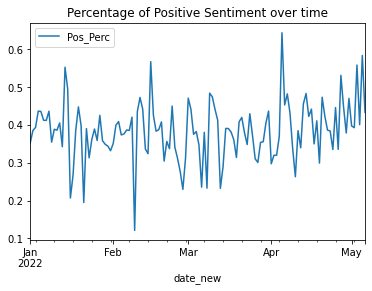

In [24]:
# Plotting the trend charts

sentiment_time.plot('date_new' , 'Pos_Perc', title = "Percentage of Positive Sentiment over time")

<AxesSubplot:title={'center':'Percentage of Negative Sentiment over time'}, xlabel='date_new'>

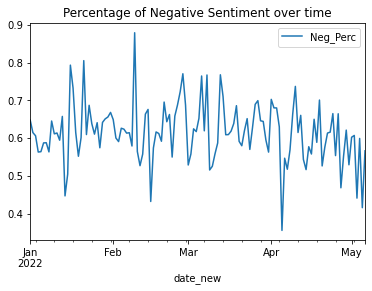

In [25]:
sentiment_time.plot('date_new' , 'Neg_Perc', title = "Percentage of Negative Sentiment over time")

<AxesSubplot:title={'center':'Count of Positive Sentiment over time'}, xlabel='date_new'>

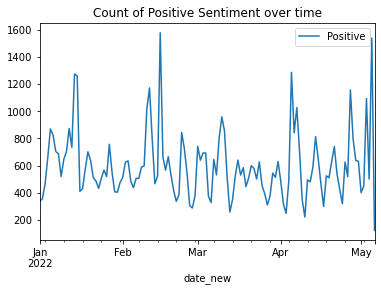

In [26]:
sentiment_time.plot('date_new' , 'Positive', title = "Count of Positive Sentiment over time")

<AxesSubplot:title={'center':'Count of Negative Sentiment over time'}, xlabel='date_new'>

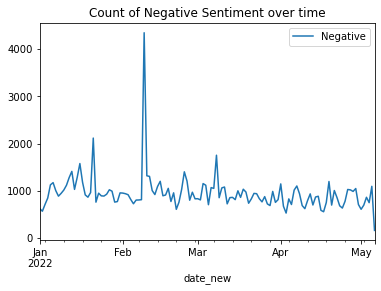

In [27]:
sentiment_time.plot('date_new' , 'Negative', title = "Count of Negative Sentiment over time")